In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basic_functions as bf
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore") 

In [23]:
path = '../namesbystate/'
state = 'merged'
full_path = path+state+'.csv'
data_set = pd.read_csv(full_path)

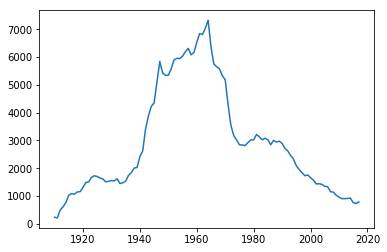

In [24]:
data=bf.get_year("CA","John")
dataM=data[data["Gender"]=="M"]
plt.plot(dataM["Year"],dataM["Occurence"])

In [25]:
#Methode brute pour choisir les paramètres

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [47]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries["Occurence"].rolling(15).mean()
    rolstd =timeseries["Occurence"].rolling(15).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries["Year"],timeseries["Occurence"], color='blue',label='Original')
    mean = plt.plot(timeseries["Year"],rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries["Year"],rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["Occurence"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput


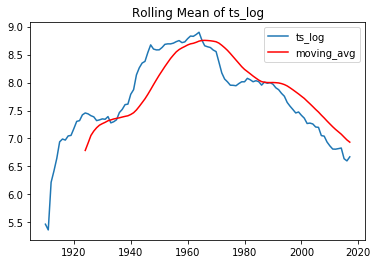

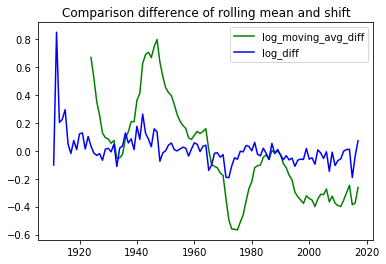

(107, 2)


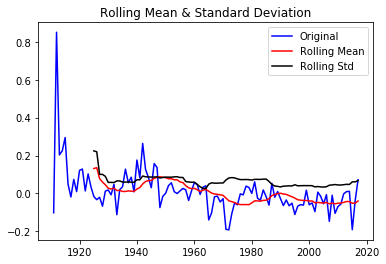

Results of Dickey-Fuller Test:


In [51]:
ts_log = np.log(dataM["Occurence"])

#Method 1 of removing trend 
moving_avg = ts_log.rolling(15).mean()
plt.plot(dataM["Year"],ts_log,label="ts_log")
plt.plot(dataM["Year"],moving_avg, color='red',label="moving_avg")

plt.title('Rolling Mean of ts_log')
plt.legend(loc='best')
plt.show()

ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(dataM["Year"],ts_log_moving_avg_diff, color="green",label="log_moving_avg_diff")


#Method 2 IS BETTER
ts_log_diff = ts_log - ts_log.shift()

plt.plot(dataM["Year"],ts_log_diff, color = 'blue',label="log_diff")
plt.legend(loc='best')
plt.title('Comparison difference of rolling mean and shift')
plt.show()

#Recreate timeseries with result of method 2
new_ts=pd.concat([dataM["Year"],ts_log_diff],axis=1)
new_ts.dropna(inplace=True)
print(new_ts.shape)

result=test_stationarity(new_ts)
if (not result["Test Statistic"]<result['Critical Value (1%)']):
    raise ValueError("La courbe n'est pas stationnaire !")

#Stationnaire avec confiance de 99%

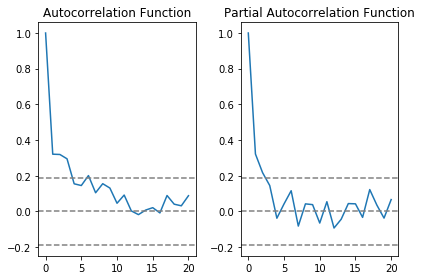

In [52]:
lag_acf = acf(new_ts["Occurence"], nlags=20)
lag_pacf = pacf(new_ts["Occurence"], nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Obtenir p = premier x tel que la courbe coupe l'interval supérieur de confiance
p=0
while lag_acf[p]>1.96/np.sqrt(len(new_ts)) and p<len(lag_acf):
    p+=1

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Obtenir q = premier x tel que la courbe coupe l'interval supérieur de confiance
q=0
while lag_acf[q]>1.96/np.sqrt(len(new_ts)) and q<len(lag_acf):
    q+=1

Error: Chosen p and q don't work!!


Text(0.5,1,'RSS: 1.3547')

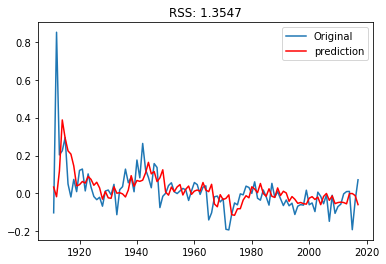

In [53]:
try:
    model = ARIMA(ts_log, order=(p, 1, q))
    results_AR = model.fit(disp=-1) #Seems that it also works without this ? TODO Check
except:
    print ("Warning: Chosen p and q don't work!!")
    model = ARIMA(ts_log, order=(p, 1, q-1))
    
    
results_AR = model.fit(disp=-1) #Uses Kalman filter to fit    
 
new_ts.dropna(inplace=True)
plt.plot(new_ts["Year"],new_ts["Occurence"],label="Original")
plt.plot(dataM["Year"][1:],results_AR.fittedvalues, color='red',label="prediction")
plt.legend(loc="best")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-new_ts["Occurence"])**2))


Text(0.5,1,'RMSE: 887.1476')

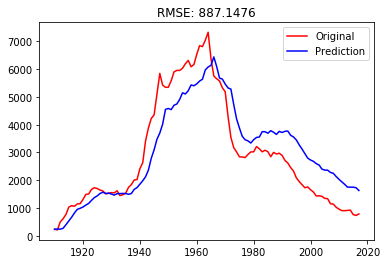

In [55]:
#Fait les opérations inverses pour avoir la prédiction avec trend et seasonality
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
#print (predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print (predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(dataM["Year"],dataM["Occurence"],color="red",label="Original")
plt.plot(dataM["Year"],predictions_ARIMA,color="blue",label="Prediction")
plt.legend(loc="best")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-dataM["Occurence"])**2)/len(dataM["Occurence"])))

# Remarques:

Marche plus ou moins bien suivant les prénoms.

Texas:
- John ok
- Lucas ok
- Bob non
- Jaime non

CA:
- John ok
- Sophie non
- Marie bof: tendance, mais courbes éloignées
- Catherine bof: idem :'(

Même si la confiance est de 99% pour la stationnarité, la prédiction n'est pas géniale parfois.

En utilisant ACF et PACF, la plupart du temps, on devrait choisir p=1, q=1, mais ça bugue. Il faut mettre ARIMA(ts_log, order=(2, 1, 2)). J'ai pu mettre 1 et 1 pour Jaime, mais les résultats étaient mauvais.
Bug: ce n'est toujours pas stationnaire parfois après différentiation

## Paramètres à changer éventuellement:
- p et q et d
- time window de 15 années ====> par exemple, valeur trop grande quand c'est un nouveau prénom utilisé que récemment (genre Khaleesi). En même temps, pour ces prénoms, c'est encore plus dur de prédire leur tendance et il y a très peu de chance qu'ils deviennent les prénoms les plus popula
- les prénoms et states

